# Домашнее задание - линейная регрессия

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [9]:
df = pd.read_csv("https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv")

In [5]:
report = df.profile_report(
    sort=None, html={"style": {"full_width": True}}, progress_bar=False
)
report

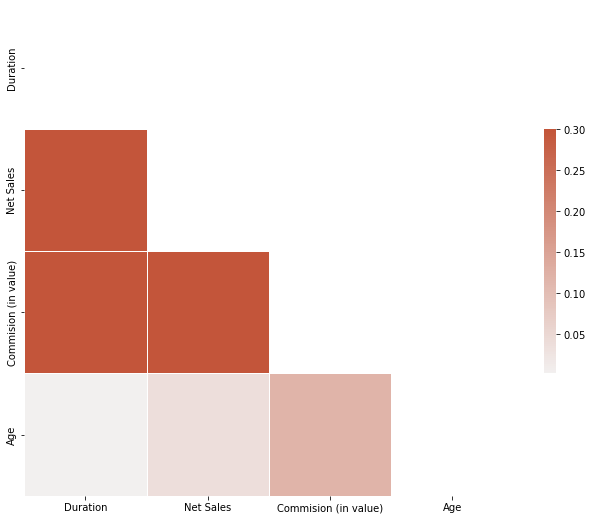

In [10]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df['Claim'] = df['Claim'].apply(lambda x: 1 if x=='Yes' else 0)

Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели. 

1. Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)

2. Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.

3. Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.

4. Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

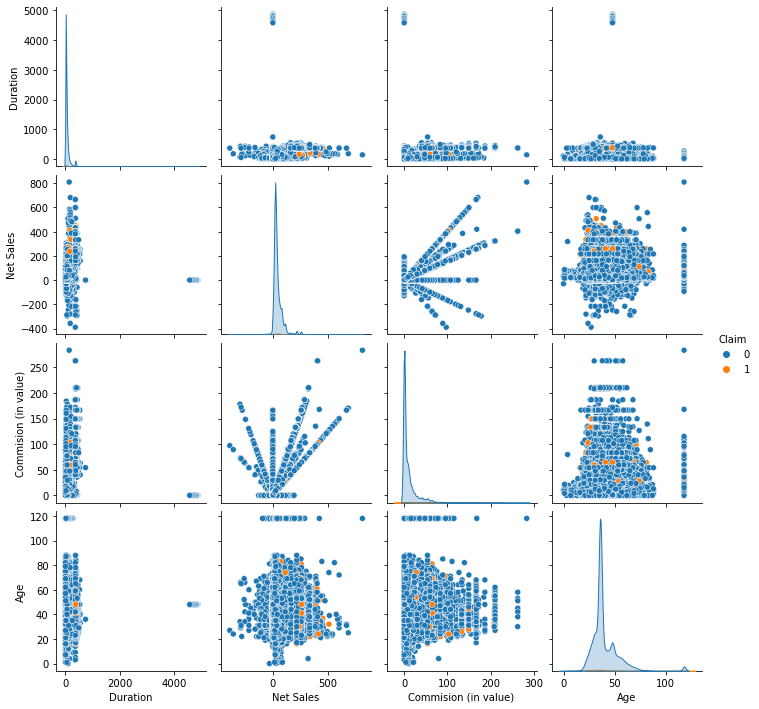

In [13]:
sns.pairplot(df, hue="Claim")

In [14]:
top_agency = ["EPX","CWT", "C2B"]
df['Agency'] = df['Agency'].apply(lambda x: 'Other' if x not in top_agency else x)

In [15]:
top_product = [
    'Cancellation Plan',
    '2 way Comprehensive Plan',
    'Rental Vehicle Excess Insurance',
    'Basic Plan',
    'Bronze Plan'
]
df['Product Name'] = df['Product Name'].apply(lambda x: 'Other' if x not in top_product else x)

In [16]:
top_destination = ['SINGAPORE', 'THAILAND', 'MALAYSIA', 'CHINA', 'AUSTRALIA',
                   'INDONESIA', 'UNITED STATES', 'HONG KONG', 'PHILIPPINES', 'JAPAN',
                   'KOREA, REPUBLIC OF', 'VIET NAM', 'INDIA']
df['Destination'] = df['Destination'].apply(lambda x: 'Other' if x not in top_destination else x)

In [17]:
overprice = df[df["Net Sales"]<df["Commision (in value)"]]
df.drop(index=overprice.index.values, inplace = True)

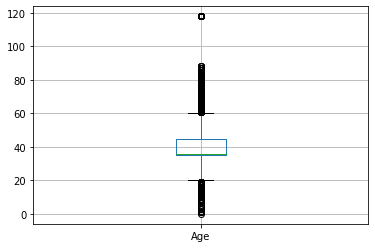

In [18]:
boxplot1 = df.boxplot(column=['Age'])

In [19]:
toooo_old = df[df['Age']>115]
df.drop(index=toooo_old.index.values, inplace = True)

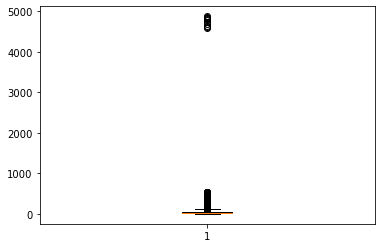

In [20]:
fig = plt.figure(figsize =(6,4 ))
plt.boxplot(df['Duration'])
plt.show()

In [21]:
df.drop(index=df[df['Duration']==0].index.values, inplace = True)

In [22]:
df.drop(index=df[df['Duration']>400].index.values, inplace = True)

In [23]:
df["Gender"].fillna("Not Specified",inplace=True)

In [24]:
df.drop('Gender', axis=1, inplace = True)

In [25]:
report = df.profile_report(
    sort=None, html={"style": {"full_width": True}}, progress_bar=False
)
report

In [26]:
df

Agency Agency Type Distribution Channel Product Name  Claim  Duration  \
21       C2B    Airlines               Online  Bronze Plan      0        12   
22       C2B    Airlines               Online  Bronze Plan      0         7   
23       C2B    Airlines               Online  Bronze Plan      1        12   
24       C2B    Airlines               Online        Other      0       190   
25       C2B    Airlines               Online        Other      0       364   
...      ...         ...                  ...          ...    ...       ...   
63320  Other    Airlines               Online   Basic Plan      0         5   
63321  Other    Airlines               Online   Basic Plan      0       111   
63322  Other    Airlines               Online   Basic Plan      0        58   
63323  Other    Airlines               Online   Basic Plan      0         2   
63325  Other    Airlines               Online   Basic Plan      0        22   

      Destination  Net Sales  Commision (in value)  Age  
21      SINGAPORE      46.15                 11.54   44  
22      SINGAPORE      17.55                  4.39   25  
23      SINGAPORE      94.00                 23.50   34  
24      SINGAPORE     294.75                 73.69   26  
25      SINGAPORE     389.00                 97.25   30  
...           ...        ...                   ...  ...  
63320       Other      18.00                  6.30   27  
63321       JAPAN      35.00                 12.25   31  
63322       CHINA      40.00                 14.00   40  
63323    MALAYSIA      18.00                  6.30   57  
63325   HONG KONG      26.00                  9.10   35  

[52484 rows x 10 columns]

In [27]:
X, Y = df.drop(['Claim'], axis=1, inplace = False), df['Claim']

In [28]:
def onehot_encoding(x):
    n = len(np.unique(x))
    keys = sorted(np.unique(x))
    X = np.arange(n * len(x)).reshape(len(x), n)
    for i in range(len(x)):
        m = np.zeros(n)
        m[keys.index(x[i])] = 1
        X[i] = np.array(m)
    return X

def minmax_scale(X, min=0, max=1):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min
    X_scaled = np.nan_to_num(X_scaled,0.)
    return X_scaled

In [29]:
cat_features_mask = (X.dtypes == "object").values

In [30]:
cat_features  = X[X.columns[~~cat_features_mask]]

In [31]:
num_features = X[X.columns[~cat_features_mask]]

In [32]:
num_features

Duration  Net Sales  Commision (in value)  Age
21           12      46.15                 11.54   44
22            7      17.55                  4.39   25
23           12      94.00                 23.50   34
24          190     294.75                 73.69   26
25          364     389.00                 97.25   30
...         ...        ...                   ...  ...
63320         5      18.00                  6.30   27
63321       111      35.00                 12.25   31
63322        58      40.00                 14.00   40
63323         2      18.00                  6.30   57
63325        22      26.00                  9.10   35

[52484 rows x 4 columns]

In [ ]:
onehot_encoding(cat_features["Agency"].values)

In [34]:
cat = np.array(np.concatenate([onehot_encoding(cat_features[i].values) for i in cat_features], axis=1))
num = minmax_scale(num_features.to_numpy())

In [69]:
X = np.concatenate((num,cat), axis=1)

В итоге я удаляю все cat_features((((((( на тестах они мешают

In [85]:
X = num

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(  
X, Y, test_size = 0.2, random_state = 100, stratify=Y)

Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2. 

In [87]:
class DummyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        """
        фукнкция обучения - вычисляет параметры модели (веса) по данной выборке
        
        Inputs:
        X - матрица признаков
        y - вектор ответов
        
        Outputs:
        self - модель
        """
        
        n, k = X.shape
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((np.ones((n, 1)), X))

        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), X_train.T), y)
        
        return self
        
    def predict(self, X):
        """
        функция предсказания - предсказывает ответы модели по данной выборке
        
        Inputs:
        X - матрица признаков
        
        Outputs:
        y_pred - предсказания
        """
        
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((np.ones((n, 1)), X))

        y_pred = np.dot(X_train, self.w)

        return y_pred
    
    def get_weights(self):
        return self.w


# класс линейной регрессии с помощью аналитического решения c регуляризацией
class DummyLinearRegressionWithRegularization(DummyLinearRegression):
    def __init__(self, fit_intercept=True):
        super().__init__(fit_intercept)

    def fit_with_l2(self, X, y):
        """
        функция обучения - вычисляет параметры модели (веса) по данной выборке, c учетом регуляризации
        
        Inputs:
        X - матрица признаков
        y - вектор ответов
        
        Outputs:
        self - модель
        """
        
        # 1 a11 a12 a13 * (w0, w1, w2, w3)
        # 1 a21 ...
        # 1 a31 ...
        
        n, k = X.shape
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((np.ones((n, 1)), X))
            
        # X_train - n, k + 1
        # X.shape[1] = k
        # X_train.shape[1] = k + 1
        # 1 a11 a12 a13
        # 1
        # 1
        # X_train.T * X_train -> k + 1, k + 1
        l = 1

        self.w = np.linalg.inv(X_train.T @ X_train + l * np.eye(k + 1)) @ X_train.T @ y
        return self
    def predict(self, X):
        """
        функция предсказания - предсказывает ответы модели по данной выборке
        
        Inputs:
        X - матрица признаков
        
        Outputs:
        y_pred - предсказания
        """
        
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((np.ones((n, 1)), X))

        y_pred = np.dot(X_train, self.w)

        return y_pred
    

In [88]:
custom_linear_regressor = DummyLinearRegression().fit(X_train, y_train)
custom_predictions = custom_linear_regressor.predict(X_test)

custom_linear_regressor_l2 = DummyLinearRegressionWithRegularization().fit_with_l2(X_train, y_train)
custom_predictions_l2 = custom_linear_regressor_l2.predict(X_test)

In [89]:
custom_linear_regressor.get_weights(), custom_linear_regressor_l2.get_weights()

(array([ 0.010251  ,  0.02750582,  0.17670653,  0.0343293 , -0.02081146]),
 array([ 0.01031179,  0.027814  ,  0.17464219,  0.03527436, -0.02081011]))

Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [90]:
# обучите модель линейной регрессии LinearRegression на обучающей выборке, примените к тестовой

In [91]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression().fit(X_train, y_train)
predictions = linear_regressor.predict(X_test)

In [92]:
#парачка проб пера для проверки

In [93]:
from sklearn.linear_model import RidgeCV
Rid = RidgeCV().fit(X_train, y_train)
Rid_predictions = Rid.predict(X_test)

In [94]:
sig = lambda x: 1/(1 + np.exp(-x))

In [95]:
ceil = lambda x: np.around(sig(x))

In [96]:
dummy_ceil = lambda x: np.around(x)

In [98]:
from sklearn.metrics import mean_absolute_error
all_pred = (custom_predictions, custom_predictions_l2, predictions, Rid_predictions)
all_pred = tuple(map(ceil, all_pred))
for y_pred in all_pred:
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

MAE: 0.9743736305611127
MAE: 0.974468895875012
MAE: 0.9743736305611127
MAE: 0.974468895875012


In [64]:
(custom_predictions[:20], custom_predictions_l2[:20], predictions[:20], Rid_predictions[:20])

(array([2.65182393e-02, 2.86292423e-02, 1.28049092e-02, 6.46527084e-03,
        3.39597316e-02, 2.32077878e-02, 1.89349538e-03, 9.01267460e-02,
        8.17966479e-03, 1.01678229e-02, 2.50228880e-02, 9.33491570e-05,
        2.21897213e-02, 8.40254936e-03, 1.18137517e-02, 1.17898512e-02,
        1.30697088e-02, 4.92497979e-02, 2.04317206e-02, 4.60663994e-02]),
 array([0.02635319, 0.02857679, 0.0127827 , 0.00652028, 0.03404651,
        0.02320232, 0.00189928, 0.09001273, 0.00821455, 0.01019093,
        0.02491464, 0.00011062, 0.02217779, 0.00840811, 0.01186939,
        0.01173848, 0.01305021, 0.04935216, 0.02060857, 0.04606324]),
 array([2.65182393e-02, 2.86292423e-02, 1.28049092e-02, 6.46527084e-03,
        3.39597316e-02, 2.32077878e-02, 1.89349538e-03, 9.01267460e-02,
        8.17966479e-03, 1.01678229e-02, 2.50228880e-02, 9.33491570e-05,
        2.21897213e-02, 8.40254936e-03, 1.18137517e-02, 1.17898512e-02,
        1.30697088e-02, 4.92497979e-02, 2.04317206e-02, 4.60663994e-02]),
 a

### Вывод (1 балла)

Над фичами провел нормальную работу, почистил по изучал, датасет не очень, данные ответов не сбалансированы из-за этого сложно сказать хорошо работает модель или плохо и сравнить ее сложно. Тут лучше подходит логическая регрессия которая спокойно решает задачи бинарной классификации.


In [ ]:
"""
[^._.^]ﾉ彡 ◟[˳_˳]ʌ˽ʌ (=✖ ᆺ ✖=)
"""